In [1]:
from pkg.word2vec_vocab import docs_to_vocab_ids,embedding_matrix

import numpy as np
import re

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import tensorflow_text as tf_text

from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding,Flatten,Dense,SpatialDropout1D,LSTM
from keras.callbacks import EarlyStopping

import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import pandas as pd
pd.set_option('max_columns', None)

from pkg.data_frame import eda_nltk, remove_tags

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes = True)


import warnings
warnings.filterwarnings("ignore")



[nltk_data] Downloading package word2vec_sample to
[nltk_data]     /Users/peeti_mac/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!
2023-09-13 23:06:57.305328: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/peeti_mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
dataframe = input(': ') #data/reviews_Automotive_5.json.gz
df = eda_nltk(dataframe)
df.head()

: data/reviews_Automotive_5.json.gz


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car...,5,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but ...",4,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]",Can't comment much on these since they have no...,5,Looks and feels heavy Duty,1374710400,"07 25, 2013"
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]",I absolutley love Amazon!!! For the price of ...,5,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010"
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]",I purchased the 12' feet long cable set and th...,5,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012"


# EDA
## add a new column for sentiment


(20473, 10)


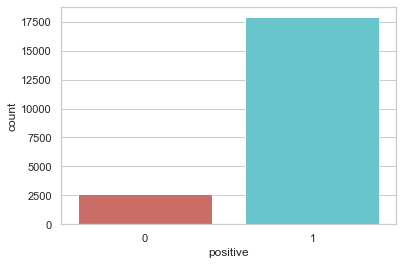

In [4]:
df['positive'] = df.overall.apply(lambda x: 1 if x >= 4 else 0)
print(df.shape)

review_df = df[['reviewText','positive']]
review_df['reviewText']=review_df['reviewText'].apply(lambda cw : remove_tags(cw))


sns.countplot(x='positive',data = review_df, palette = 'hls')
plt.show()

## handling the imbalanced data

In [5]:
max_cnt = review_df.query('positive == 0').shape[0]
print(f'We should select only {max_cnt} count for both positive/ negative review')
sample_df = review_df.groupby(['positive']).apply(lambda x: x.sample(max_cnt))
sample_df.shape[0]

We should select only 2578 count for both positive/ negative review


5156

In [6]:
s = 0.0
for i in sample_df['reviewText']:
    word_list = i.split()
    s = s + len(word_list)
print("Average length of each review : ",s/sample_df.shape[0])
pos = 0
for i in range(sample_df.shape[0]):
    if sample_df.iloc[i]['positive'] == 1:
        pos = pos + 1
neg = sample_df.shape[0]-pos
print("Percentage of reviews with positive sentiment is "+str(pos/sample_df.shape[0]*100)+"%")
print("Percentage of reviews with negative sentiment is "+str(neg/sample_df.shape[0]*100)+"%")

Average length of each review :  96.65244375484872
Percentage of reviews with positive sentiment is 50.0%
Percentage of reviews with negative sentiment is 50.0%


# let's tokenize the data

In [7]:
sample_df[:2]['reviewText']

positive       
0         17723    its very comfortable who ever owns a jk knows ...
          15280    put this into a jeep 3 7l v6 engine after one ...
Name: reviewText, dtype: object

In [8]:
X = sample_df['reviewText']
y = sample_df['positive']
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2)

In [9]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(X_train)
test_tokens = tokenizer.tokenize(X_test)

train_tokens[0]

<tf.Tensor: shape=(180,), dtype=string, numpy=
array([b'all', b'in', b'all', b'it', b'took', b'me', b'a', b'little',
       b'while', b'to', b'get', b'these', b'set', b'up', b'on', b'my',
       b'1982', b'yamaha', b'xj650', b'once', b'i', b'found', b'a',
       b'configuration', b'that', b'i', b'liked', b'and', b'worked',
       b'for', b'me', b'i', b'loaded', b'some', b'random', b'things',
       b'in', b'to', b'the', b'bags', b'and', b'took', b'a', b'spin',
       b'they', b'did', b'quite', b'well', b'very', b'little', b'sag',
       b'from', b'the', b'bags', b'i', b'think', b'these', b'will', b'be',
       b'great', b'for', b'long', b'rides', b'to', b'carry', b'water',
       b'snacks', b'rain', b'gear', b'spare', b'visor', b'and', b'some',
       b'extra', b'tools', b'i', b'suggest', b'these', b'bags', b'if',
       b'you', b'don', b't', b'want', b'to', b'invest', b'in', b'leather',
       b'or', b'pvc', b'bags', b'or', b'just', b'want', b'something',
       b'to', b'carry', b'som

In [10]:
train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)

train_labels = np.array(Y_train)
test_labels = np.array(Y_test)

test_labels[:4]

Examples processed:  0
Total examples:  4123
Examples processed:  0
Total examples:  1031


array([1, 0, 1, 0])

In [11]:
def build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)
    
    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
    
    cnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return cnn_model

In [12]:
MAX_SEQUENCE_LENGTH = 128
num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5

cnn_model = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate)
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 128, 300)             1319460   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 conv1d (Conv1D)             (None, 126, 100)             90100     ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 125, 100)             120100    ['embedding[0][0]']       

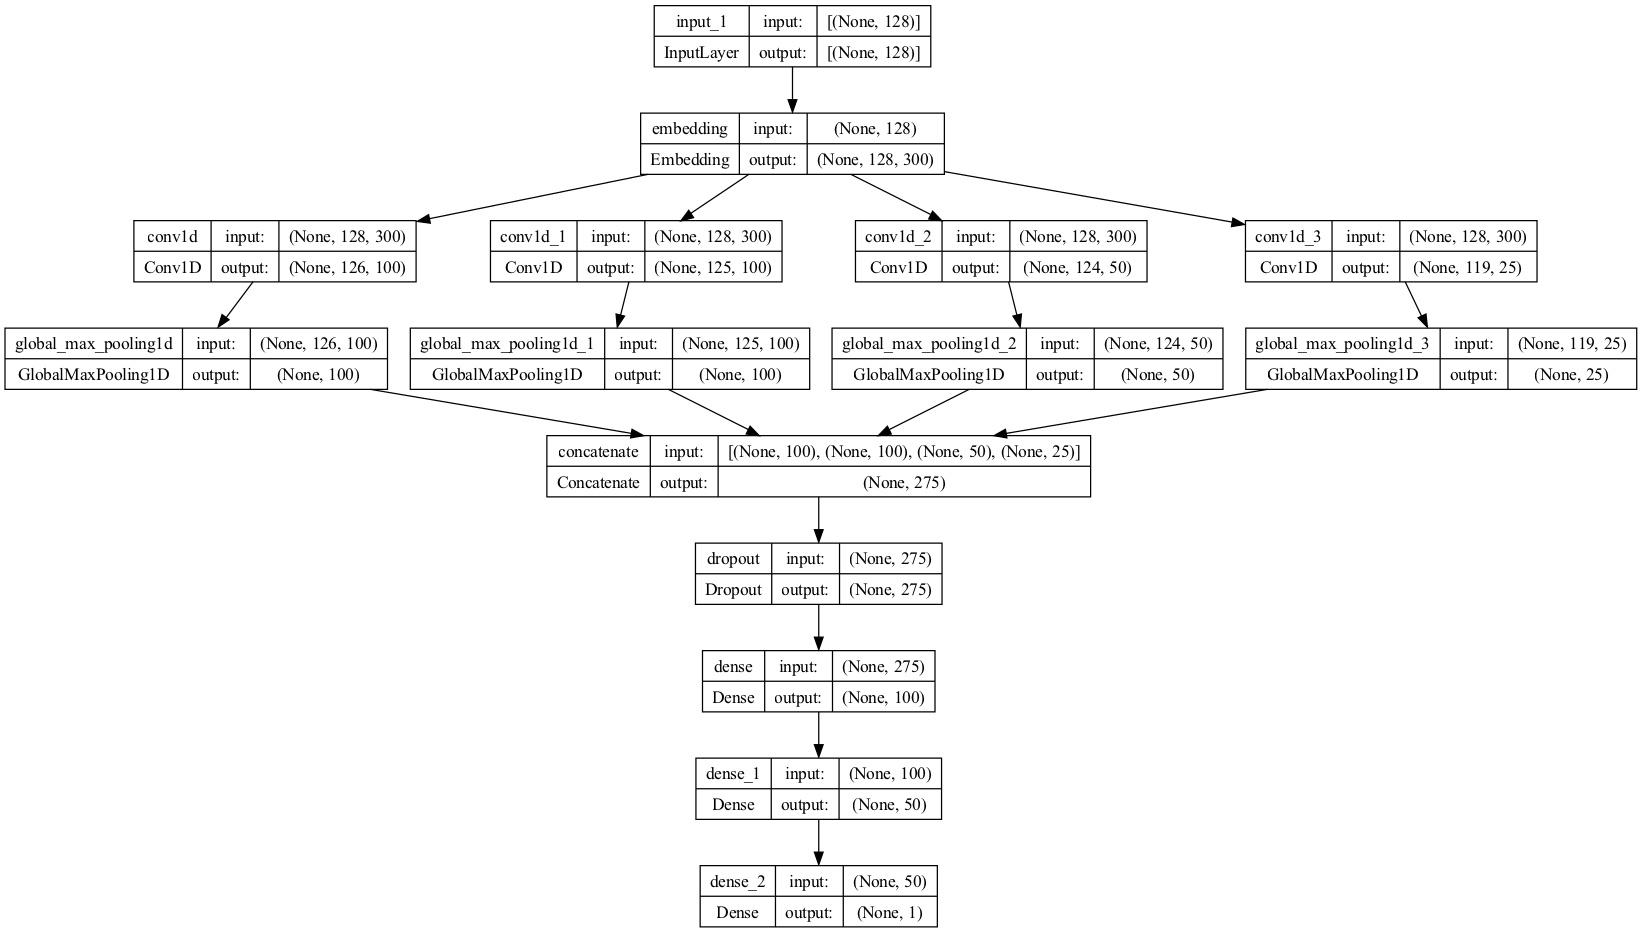

In [13]:
plot_model(cnn_model, show_shapes=True, dpi=90)

In [14]:
cnn_history = cnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
129/129 [==============================] - 10s 69ms/step - loss: 0.6710 - accuracy: 0.5805 - val_loss: 0.5965 - val_accuracy: 0.7083
Epoch 2/5
129/129 [==============================] - 9s 67ms/step - loss: 0.5747 - accuracy: 0.6986 - val_loss: 0.5469 - val_accuracy: 0.7229
Epoch 3/5
129/129 [==============================] - 9s 66ms/step - loss: 0.4887 - accuracy: 0.7653 - val_loss: 0.5191 - val_accuracy: 0.7422
Epoch 4/5
129/129 [==============================] - 9s 68ms/step - loss: 0.4010 - accuracy: 0.8164 - val_loss: 0.5181 - val_accuracy: 0.7461
Epoch 5/5
129/129 [==============================] - 9s 68ms/step - loss: 0.3055 - accuracy: 0.8698 - val_loss: 0.5196 - val_accuracy: 0.7694
